##### Copyright 2018 The TensorFlow Authors.

# Convolutional Variational Autoencoder Loader

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

![evolution of output during training](https://tensorflow.org/images/autoencoders/cvae.gif)

This notebook demonstrates how to generate images of handwritten digits by training a Variational Autoencoder ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)).



In [2]:
# to generate gifs
!pip install -q imageio

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Import TensorFlow and other libraries

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
#(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 32
TEST_BUF = 10000

epochs = 200
latent_dim = 50
conditional_vae = True

dir_path = "{:s}vae/z-{:03d}".format("cond-" if conditional_vae else "", latent_dim)

if not os.path.exists(dir_path):
    raise ValueError("Directory not found!")

## Use *tf.data* to create batches and shuffle the dataset

In [7]:
if conditional_vae:
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)
                                                      ).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)
                                                     ).shuffle(TEST_BUF).batch(BATCH_SIZE)
else:
    train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

## Wire up the generative and inference network with *tf.keras.Sequential*

In our VAE example, we use two small ConvNets for the generative and inference network. Since these neural nets are small, we use `tf.keras.Sequential` to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [8]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, conditional_vae=False):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.conditional_vae = conditional_vae
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1+10 if self.conditional_vae else 1)),
                tf.keras.layers.Conv2D(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation=tf.nn.leaky_relu),
                tf.keras.layers.Conv2D(
                    filters=64,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation=tf.nn.leaky_relu),
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(
                    input_shape=(latent_dim+10 if self.conditional_vae else latent_dim,)),
                tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
                #tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=2,
                    padding="SAME",
                    activation='relu'),
                #tf.keras.layers.BatchNormalization(),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1,
                    kernel_size=3,
                    strides=2,
                    padding="SAME"),
            ]
        )
    
    @tf.function
    def sample(self, eps=None, y=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, y=y, apply_sigmoid=True)

    def encode(self, x, y=None):
        if self.conditional_vae:
            # turn the classes numbers into one-hot vectors then reshape the vectors for further operations
            y = tf.reshape(tf.one_hot(y, 10), (y.shape[0], 1, 1, 10))
            # inputs shape will be (batch_size, 28, 28, 10+1)
            inputs = tf.concat([x, y * tf.ones([y.shape[0],28,28,10])], 3)
        else:
            inputs = x        
        mean, logvar = tf.split(self.inference_net(inputs), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # logvar = log(sigma^2)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, y=None, apply_sigmoid=False):
        if self.conditional_vae:
            # turn the classes numbers into one-hot vectors
            y = tf.one_hot(y, 10)
            # inputs_k shape will be (batch_size, k, latent_dim+10)
            inputs = tf.concat([z, y], 1)
        else:
            inputs = z
        logits = self.generative_net(inputs)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [9]:
def log_normal_pdf(sample, mean, logvar, raxis=-1):
    #      normal_pdf = 1/(sigma*(2*pi)^1/2) * exp(-0.5*(x-mu)^2/sigma^2)
    # log(normal_pdf) = -log(sigma) - 0.5*log(2*pi) -0.5*(x-mu)^2/sigma^2
    #                 = -0.5 * ((x-mu)^2/sigma^2 + 2*log(sigma) + log(2*pi))
    #                 = -0.5 * ((x-mu)^2/exp(logvar) + logvar + log(2*pi)), where logvar = log(sigma^2)
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

@tf.function
def compute_loss(model, x, y=None):
    mean, logvar = model.encode(x, y=y)
    z = model.reparameterize(mean, logvar)
    x_logits = model.decode(z, y=y)

    # NOTE: The shapes of log(p(x|z)), log(p(z)) & log(g(z|x)) are (batch size, k)
    #
    # With logistic regression (i.e., binarized data), x_hat = sigmoid(logits), x = labels:
    #     cross entropy = x * -log(x_hat) + (1 - x) * -log(1 - x_hat)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)
    #      p(x|z) = Bernoulli(x;DNN(z)) = Bernoulli(x;x_hat)
    #             = sum(x_hat^x * (1-x_hat)^(1-x))
    # log(p(x|z)) = sum(x*log(x_hat) + (1-x)*log(1-x_hat))
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
        
    # NOTE: the shape of log_weight is (batch size, k) 
    log_weights = logpx_z + logpz - logqz_x
    
    ### VAE
    ### loss = -E[ average( log( p(zi)*p(x|zi)/q(zi|x) ) ) ] = -E[ average( log(p(zi)) + log(p(x|zi)) - log(q(zi|x)) ) ]
    return -tf.reduce_mean(log_weights)

## Generate Images

* After training, it is time to generate some images
* We start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Here we plot the probabilities of Bernoulli distributions


In [10]:
model = CVAE(latent_dim, conditional_vae)
model.inference_net.summary()
model.generative_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
Total params: 335,396
Trainable params: 335,396
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3136)              191296    
____________________________

## Load model weights

In [11]:
# Set the learning phase to False
tf.keras.backend.set_learning_phase(False)
    
model.load_weights(os.path.join(dir_path, "epcho-{:03d}.ckpt".format(epochs)))

if False:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        if isinstance(test_x, tuple):
            loss(compute_loss(model, test_x[0], test_x[1]))
        else:
            loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print("Test set ELBO: {}".format(elbo))

## Random tests

In [12]:
@tf.function
def losses(x, y=None):
    # check dimension
    if len(x.shape) != 4:
        # reshape the x to fit the input shape of the encoder
        x = x.reshape(1,28,28,1)
        if conditional_vae and y:
            y = np.array(y).reshape(1)

    if conditional_vae and y is not None:
        mean, logvar = model.encode(x, y)
        z = model.reparameterize(mean, logvar)
        x_logits = model.decode(z, y)
    else:
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar)
        x_logits = model.decode(z)
    
    logpx_z = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x), axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    
    log_weights = logpx_z + logpz - logqz_x
    
    ### VAE
    ### loss = -E[ average( log( p(zi)*p(x|zi)/q(zi|x) ) ) ] = -E[ average( log(p(zi)) + log(p(x|zi)) - log(q(zi|x)) ) ]
    loss_vae = -tf.reduce_mean(log_weights)
            
    x_hat = tf.sigmoid(x_logits)
        
    # convert probabilities to samples
    eps = tf.random.uniform(x_hat.shape)
    x_hat = tf.where(eps - x_hat <= 0, tf.ones(x_hat.shape), tf.zeros(x_hat.shape))
    
    mse = tf.reduce_mean(tf.reduce_sum((x-x_hat)**2, axis=(1,2,3)))
    
    return loss_vae, mse, x_hat

def verification(x, y=None):
    _,mse,x_hat = losses(x, y)
    
    fig = plt.figure(figsize=(2, x.shape[0]))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0], 2, 2*i+1)
        plt.imshow(x[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.subplot(x.shape[0], 2, 2*i+2)
        plt.imshow(x_hat[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
    print('MSE:{}'.format(mse))

#n=np.random.randint(0, TEST_BUF-10)
#print(n)
#n=8349
#verification(test_images[n:n+10], test_labels[n:n+10])
print("Loss:{}\n MSE:{}".format(*tuple(losses(test_images, test_labels)[:-1])))

Loss:70.42687225341797
 MSE:23.87540054321289


## Data analyses

In [13]:
import matplotlib

def data_analysis(labels, images):
    if len(labels) != len(images):
        raise ValueError('The dimensions of labels and images are not the same!')
        
    # use 2d list to store the images with different labels
    sources = [[], [], [], [], [], [], [], [], [], []]
    encoded_srcs = [0]*10
    encoded_means = [0]*10
    
    for i, label in enumerate(labels):
        sources[label].append(images[i])
    # convert 2d list into 1d list
    sources = [ np.array(src) for src in sources ]
    
    categorical_means = np.empty(shape=(10, latent_dim), dtype=np.float32)
    categorical_stds = np.empty(shape=(10, latent_dim), dtype=np.float32)
    categorical_images = np.empty(shape=(10,)+images[0].shape, dtype=np.float32)
    for i in range(10):
        if conditional_vae:
            encoded_means[i], logvar = model.encode(sources[i],
                                                    np.full(shape=[sources[i].shape[0],],
                                                            fill_value=i,
                                                            dtype=np.int32))
            encoded_srcs[i] = model.reparameterize(encoded_means[i], logvar)
        else:
            encoded_means[i], logvar = model.encode(sources[i])
            encoded_srcs[i] = model.reparameterize(encoded_means[i], logvar)
        categorical_means[i] = np.mean(encoded_srcs[i], axis=0)
        categorical_stds[i] = np.std(encoded_srcs[i], axis=0)
        categorical_images[i] = np.mean(sources[i], axis=0)

    mu_logvar = np.log(np.var(np.concatenate([ mu.numpy() for mu in encoded_means ]), axis=0))
    plt.hist(mu_logvar)
    plt.xlabel('log(variance of mu)')
    plt.ylabel('number of units')
    plt.show()

    # draw the digits
    fig = plt.figure(figsize=(10, 2))
    if conditional_vae:
        outputs = model.sample(categorical_means, np.array(list(range(10))).astype(np.int32))
    else:
        outputs = model.sample(categorical_means)
    for i in range(10):
        plt.subplot(2, 10, i+1)
        plt.imshow(categorical_images[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 10, 10+i+1)
        plt.imshow(outputs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
    
    return encoded_srcs, categorical_means, categorical_stds

In [14]:
def heatmaps(categorical_means, categorical_stds):
    # draw the correlations of means
    fig, ax = plt.subplots(figsize=(latent_dim/2.5, 5))
    ax.imshow(categorical_means, cmap='RdGy')
    ax.set_xticks(np.arange(latent_dim))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(latent_dim))
    ax.set_yticklabels(np.arange(10))
    ax.set_ylabel('Digit')
    ax.set_xlabel('Latent Space')
    threshold = 2*np.std(categorical_means)
    bias = np.mean(categorical_means) - 0.25 * threshold
    for i in range(10):
        for j in range(latent_dim):
            text = ax.text(j, i, '{:.1f}'.format(categorical_means[i, j]),
                           ha="center", va="center",
                           color="w" if abs(categorical_means[i, j]-bias)>threshold else "k" )
    fig.suptitle('means between digits and latent spaces')
    if latent_dim > 2:
        fig.tight_layout()
    plt.show()
    
    # draw the correlations of stds
    fig, ax = plt.subplots(figsize=(latent_dim/2.5, 5))
    ax.imshow(categorical_stds, cmap='RdGy')
    ax.set_xticks(np.arange(latent_dim))
    ax.set_yticks(np.arange(10))
    ax.set_xticklabels(np.arange(latent_dim))
    ax.set_yticklabels(np.arange(10))
    ax.set_ylabel('Digit')
    ax.set_xlabel('Latent Space')
    threshold = 2*np.std(categorical_stds)
    bias = np.mean(categorical_stds) - 0.25 * threshold
    for i in range(10):
        for j in range(latent_dim):
            text = ax.text(j, i, '{:.1f}'.format(categorical_stds[i, j]),
                           ha="center", va="center",
                           color="w" if abs(categorical_stds[i, j]-bias)>threshold else "k" )
    fig.suptitle('stds between digits and latent spaces')
    if latent_dim > 2:
        fig.tight_layout()
    plt.show()

def distribution_graphs(encoded_srcs):
    # draw the distributions
    if latent_dim == 2:
        cmap = plt.cm.get_cmap('tab10',10)
        #for i in range(10):
        #    plt.plot(encoded_srcs[i][:,0], encoded_srcs[i][:,1],
        #             color=cmap(i), marker='.', linestyle='', label=i, alpha=0.3)
        #sm = plt.cm.ScalarMappable(cmap=cmap, norm=matplotlib.colors.Normalize(vmin=0,vmax=10))
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(0,9,10), boundaries=np.arange(-0.5,10,1))
        #plt.axis('equal')
        #plt.title('learned manifold')
        #plt.show()
        for i in range(10):
            plt.plot(encoded_srcs[i][:,0], encoded_srcs[i][:,1],
                     color=cmap(i), marker='.', linestyle='', label=i, alpha=1)
            plt.axis('equal')
            plt.title('learned latent-{:d} manifold'.format(i))
            plt.show()
    else:
        for i in range(10):
            plt.figure(figsize=(latent_dim/3, 5))
            plt.boxplot(np.array(encoded_srcs[i]), vert=True, patch_artist=True,
                        labels=np.arange(0, latent_dim, 1.0, dtype=np.uint8))
            plt.title('latent spaces distribution of digit {:d}'.format(i))
            plt.grid(axis='y')
            plt.show()

In [20]:
def correlation_graphs(num_imgs_per_dim, category_idx=0, mean=[[0]*latent_dim], std=[[1]*latent_dim]):
    fig = plt.figure(figsize=(num_imgs_per_dim, latent_dim))
    plt.subplots_adjust(hspace=0.4)
    
    z = np.zeros(shape=[num_imgs_per_dim*latent_dim, latent_dim], dtype=np.float32)
    
    mu = np.mean(mean, axis=0)
    sigma = np.max(std, axis=0)
    z = (z + 1) * mu
    max_z = mu + 3*sigma
    min_z = mu - 3*sigma
    for x in range(0,latent_dim):
        for i in range(num_imgs_per_dim):
            z[x*num_imgs_per_dim+i, x] = min_z[x]+(max_z[x]-min_z[x])/(num_imgs_per_dim-1)*i

    if conditional_vae:
        fig.suptitle(
            'Variations along latent spaces in category {:d}'.format(category_idx),
            y=(0.8794*latent_dim+0.5288)/latent_dim
        )
        predictions = model.sample(z, np.full(shape=[num_imgs_per_dim*latent_dim,],
                                                 fill_value=category_idx,
                                                 dtype=np.int32)
                                  )
    else:
        fig.suptitle('Variations along latent spaces', y=(0.8794*latent_dim+0.5288)/latent_dim)
        predictions = model.sample(z)

    for x in range(0,latent_dim):
        for i in range(num_imgs_per_dim):
            plt.subplot(latent_dim, num_imgs_per_dim, x*num_imgs_per_dim+i+1)
            plt.title('L{:d}:{:.1f}'.format(x,z[x*num_imgs_per_dim+i, x]))
            plt.imshow(predictions[x*num_imgs_per_dim+i, :, :, 0], cmap='gray')
            plt.axis('off')

    plt.show()

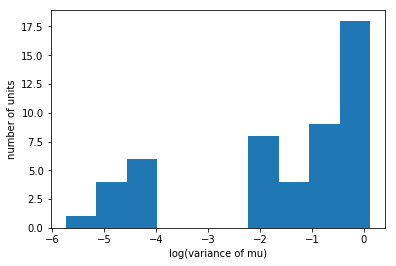

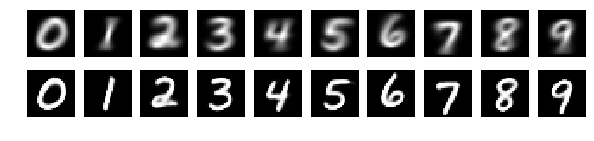

In [16]:
zs, means, stds = data_analysis(train_labels, train_images)

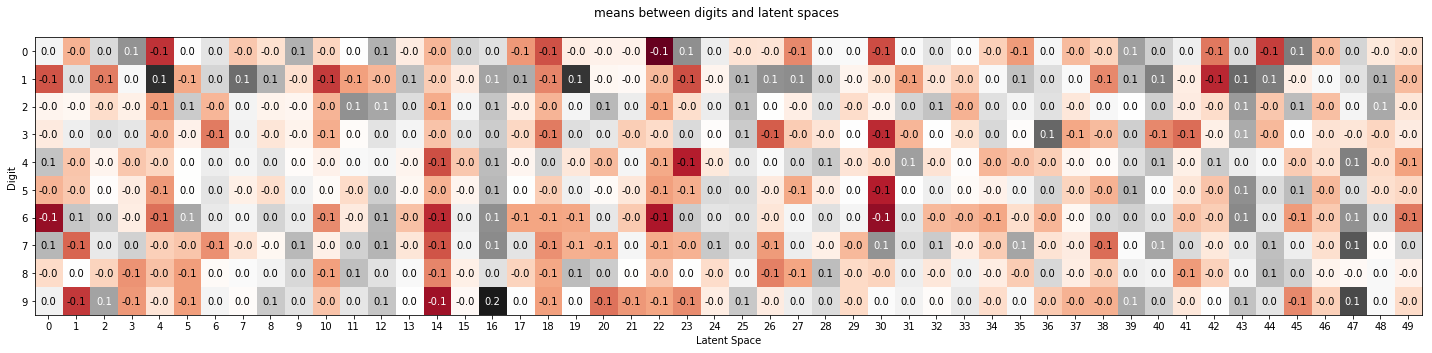

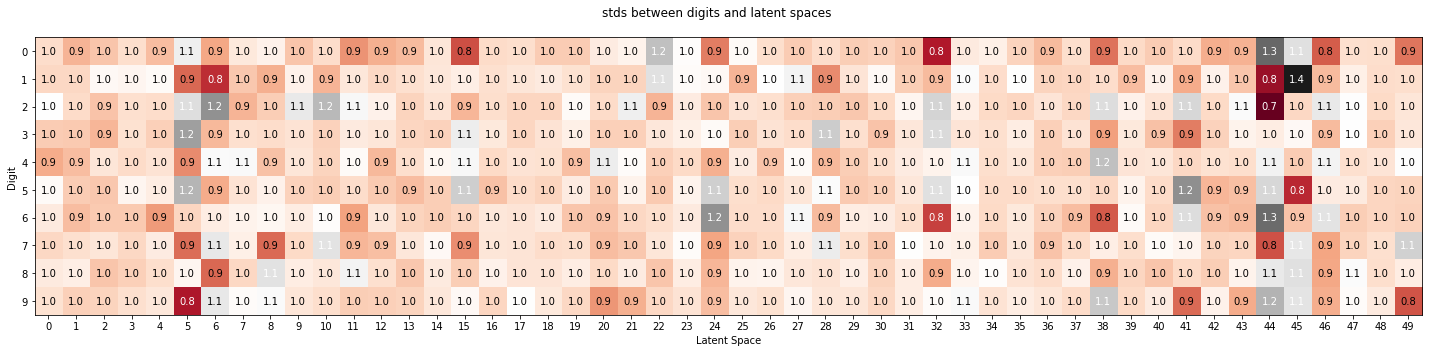

In [17]:
heatmaps(means, stds)

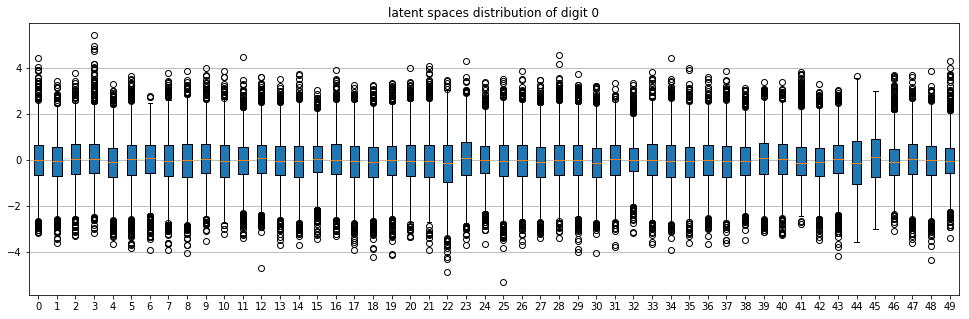

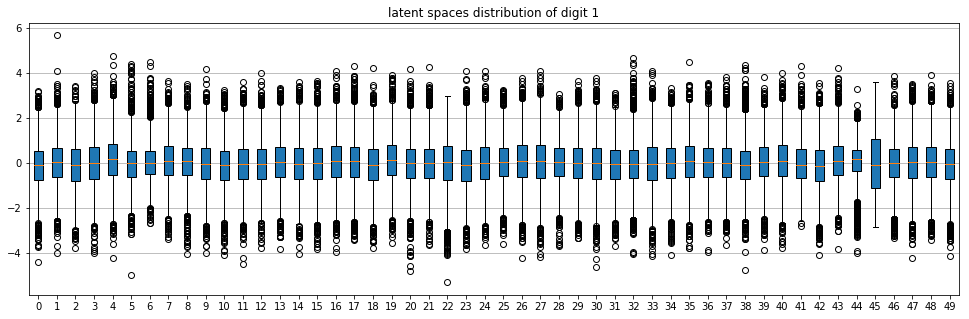

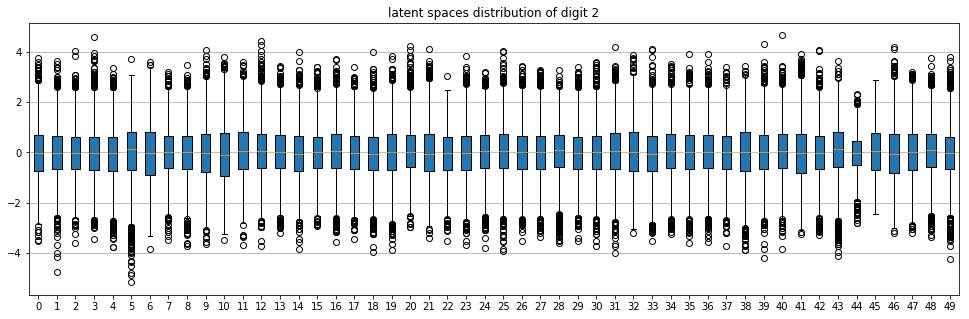

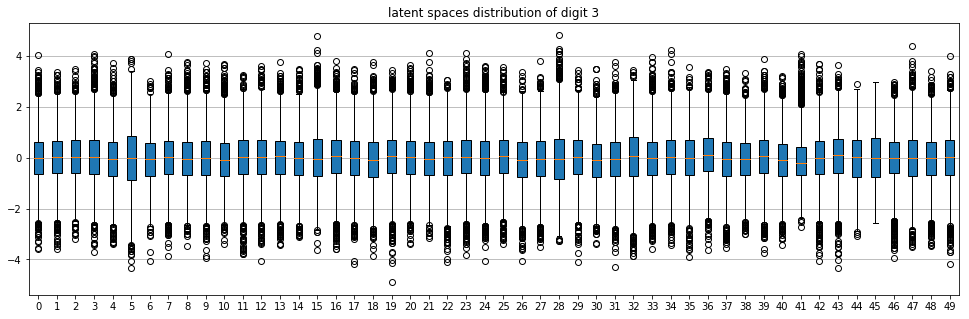

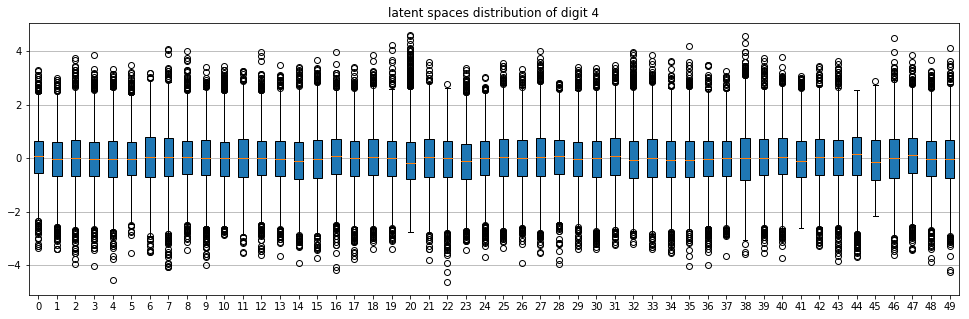

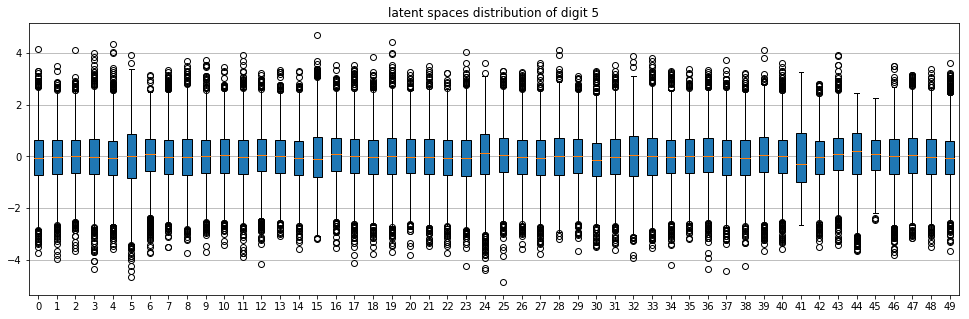

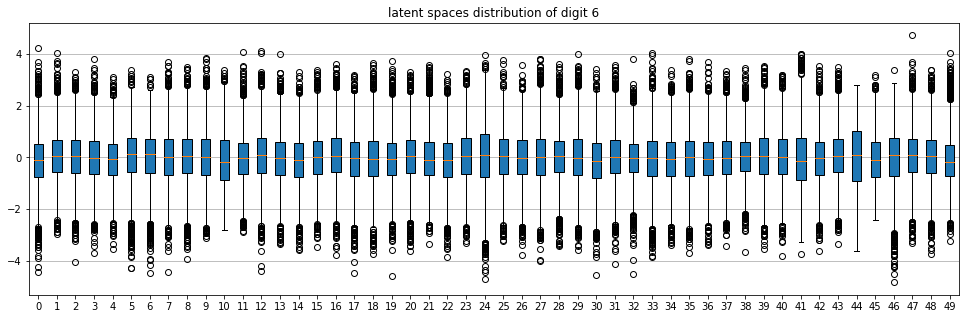

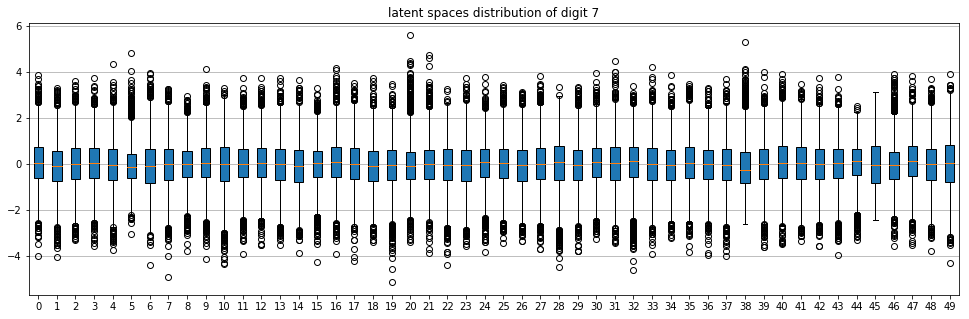

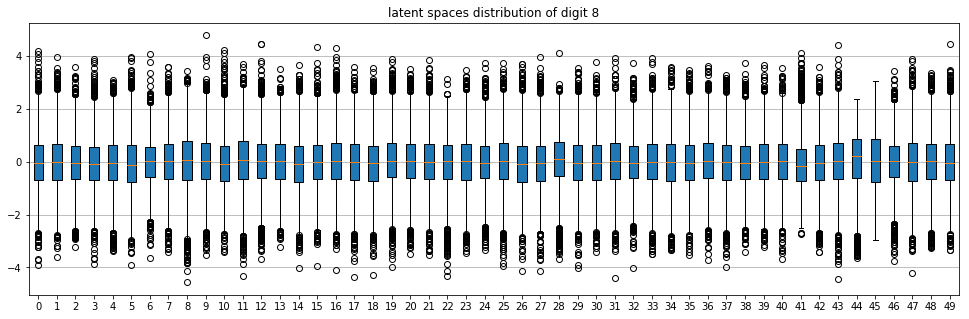

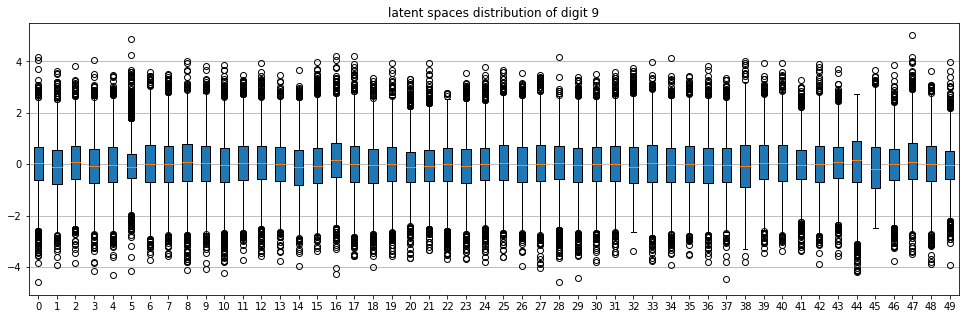

In [18]:
distribution_graphs(zs)

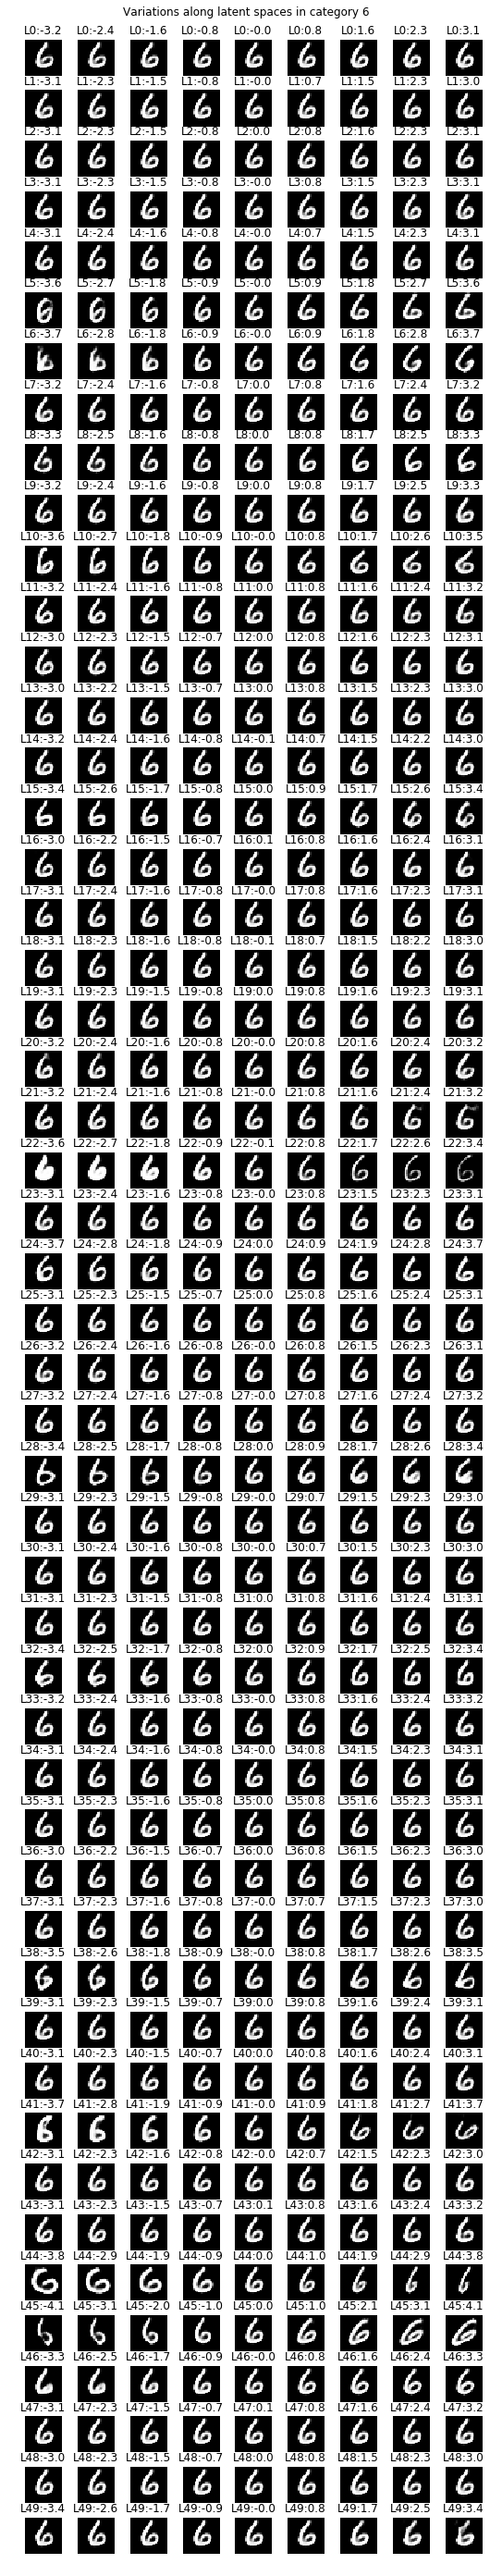

In [24]:
correlation_graphs(9, 6, mean=means, std=stds)

## Random generations

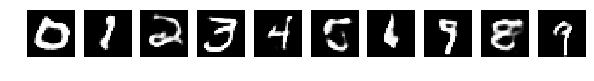

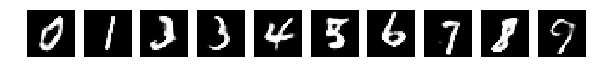

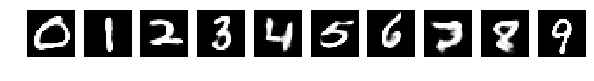

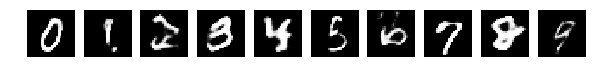

In [22]:
def patern_generator(mean, std):
    fig = plt.figure(figsize=(10, 1))
    test = np.zeros(shape=mean.shape, dtype=np.float32)
    for i in range(10):
        for j in range(latent_dim):
            # draw from uniform distribution (-1 ~ +1)
            rand = 2*(np.random.rand()-0.5)
            test[i,j] = mean[i,j] + 3*std[i,j]*rand
    if conditional_vae:
        outputs = model.sample(test, np.array(list(range(10))).astype(np.int32))
    else:
        outputs = model.sample(test)
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(outputs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

if conditional_vae:
    # only try generate the center 95% data
    #     patern_generator(mean, (2/3)*std) =
    #     mean +/- (2/3)*std*3 =
    #     mean +/- 2*std = the center 95% data in a normal distribution)
    patern_generator(means, (2/3)*stds)
    patern_generator(means, (2/3)*stds)
    patern_generator(means, (2/3)*stds)
    patern_generator(means, (2/3)*stds)
else:
    # only try generate the center 68% data
    #     patern_generator(mean, (1/3)*std) =
    #     mean +/- (1/3)*std*3 =
    #     mean +/- std = the center 68% data in a normal distribution)
    patern_generator(means, (1/3)*stds)
    patern_generator(means, (1/3)*stds)
    patern_generator(means, (1/3)*stds)
    patern_generator(means, (1/3)*stds)